In [1]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import time
import sys
import os

import seaborn as sns
import matplotlib.dates as mdates
from datetime import datetime, date

# preamble for jupyter notebook and django
import django
import platform

if platform.node() == "srv-mcc-apsis":
    sys.path.append("/home/muef/tmv/BasicBrowser/")
    #sys.path.append('/home/leey/tmv/BasicBrowser/')
    dtm_path = "/home/galm/software/dtm/dtm/main"
else:
    # local paths
    sys.path.append('/media/Data/MCC/tmv/BasicBrowser/')
    dtm_path = "/home/finn/dtm/dtm/main"

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

# import from appended path
import parliament.models as pm
from parliament.tasks import do_search, run_tm, combine_searches
import cities.models as cmodels
from django.contrib.auth.models import User
import tmv_app.models as tm
import scoping.models as sm
from utils.tm_mgmt import update_topic_scores
from django.db.models import Q, Count, Func, F, Sum, Avg, Value as V
from django.db.models.functions import TruncDate, TruncMonth, TruncYear

from utils.topic_comparison import compare_topic_queryset, save_res, sort_matrix, draw_score_matrix
from utils.topic_comparison import save_topic_list_as_table, draw_bipartite_topic_graph, bipartite_graph_from_matrix

In [2]:
#runs = tm.RunStats.objects.filter(psearch__id=63, method='BD', alpha=0.01, top_chain_var=0.005).order_by('K')
#runs = tm.RunStats.objects.filter(psearch__id=63, method='BD', K=40, alpha=0.01, status=3).order_by('top_chain_var')
runs = tm.RunStats.objects.filter(psearch__id=89, method='BD', K=45, top_chain_var=0.01, status=3).order_by('alpha')


run_ids = [run.run_id for run in runs]
run_df = pd.DataFrame.from_dict(runs.values('run_id', 'K', 'alpha',
                                'top_chain_var', 'rng_seed', 'max_iter', 'psearch__id', 'coherence', 'exclusivity',))

#run_df.set_index('run_id')
run_df = run_df.sort_values('run_id').set_index('run_id')
run_df[run_df["K"]== 45]

,K,alpha,coherence,exclusivity,max_iter,psearch__id,rng_seed,top_chain_var
run_id,,,,,,,,
2155,45,0.01,0.464178,0.878157,50,89,1,0.01
2156,45,0.05,0.473385,0.912385,50,89,1,0.01
2157,45,0.10,0.482888,0.901765,50,89,1,0.01


In [3]:
#run_ids = [1898, 1916, 1905, 1907, 1900, 2043, 2044] # runs with standard settings and K variation
#run_ids = [1902, 1905, 1899, 1901, 1915] # variation of alpha

#run_ids = [1979, 1977, 2094, 1980, 2093, 1981] # variation of alpha with pars
#run_ids = [1979, 1977, 1980, 1981]

#run_ids = [1900, 2101, 2100, 2099] # variation of top_chain_var
#runs = tm.RunStats.objects.filter(pk__in=run_ids).order_by('top_chain_var')

method = "BD"
search_name = "kohle"
topics = []
Ks = []

for run_id in run_ids:
    for topic in tm.Topic.objects.filter(run_id=run_id):
        if topic.top_words:
            print('top words: {}'.format(topic.top_words))
        else:
            terms = tm.Term.objects.filter(topicterm__topic=topic).values('title').annotate(
                        summed_score = Sum(F('topicterm__score'))).order_by('-summed_score')[:20]
            term_list = [t['title'] for t in terms]
            topic.top_words = term_list
            topic.save()

            print('assigned new top words: {}'.format(topic.top_words))
            
    topics.append(tm.Topic.objects.filter(run_id=run_id).order_by('-score'))
    stat = tm.RunStats.objects.get(run_id=run_id)
    Ks.append(stat.K)


top words: ['deutsch', 'franzos', 'frankreich', 'europa', 'deutschland', 'behord', 'vertrag', 'hoh', 'regier', 'national', 'montanunion', 'volk', 'interess', 'kohl', 'bundeskanzl', 'recht', 'entscheid', 'art', 'stahl', 'schumanplan']
top words: ['kernkraftwerk', 'kernenergi', 'ukrain', 'technisch', 'anlag', 'reaktor', 'technik', 'betrieb', 'bundesrepubl', 'tschernobyl', 'nutzung', 'gefahr', 'schnell', 'radioaktiv', 'friedlich', 'brut', 'bau', 'international', 'kraftwerk', 'wissenschaft']
top words: ['energiepolit', 'kernenergi', 'ausstieg', 'bundesregier', 'kernkraftwerk', 'kohl', 'kons', 'spd', 'entscheid', 'deutschland', 'energiemix', 'energi', 'sozialdemokrat', 'energieversorg', 'ministerprasident', 'nutzung', 'niedersachs', 'fortschreib', 'energieprogramm', 'bau']
top words: ['bundeskanzl', 'red', 'deutsch', 'damal', 'sei', 'wirklich', 'tag', 'sagt', 'letzt', 'regier', 'seit', 'wiss', 'wort', 'weiss', 'recht', 'partei', 'deutschland', 'gar', 'tun', 'zeit']
top words: ['million', 'm

In [6]:
#save_topic_list_as_table(topics[0], "topic_list_{}_{}_K{}_tei.csv".format(search_name, method, Ks[0]))

In [4]:
Ks

[45, 45, 45]

In [5]:
# Generate spread sheet with top word overlap comparison method 
% matplotlib inline

res_tw, ss, score_matrix = compare_topic_queryset(runs, order_by_str='-score')

options = {'fname': "/home/muef/coal-discourse/topic_comparison"}
save_res(runs, [res_tw,ss], options)

['run_2156_topics_45', 'scores_2156', 'similarity_2156-2155', 'run_2155_topics_45', 'scores_2155', 'similarity_2155-2157', 'run_2157_topics_45', 'scores_2157']
C2:C49
F2:F49


0

matching sum:	643.0
max rows:	657.0
max cols:	659.0


0

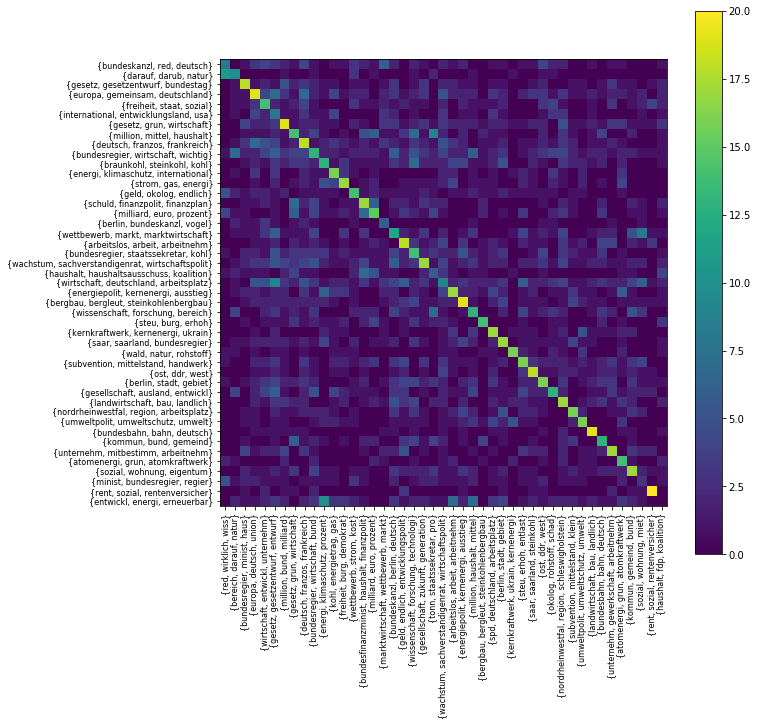

In [6]:
#draw_score_matrix(score_matrix, topics1, topics2, match=True, filename="topword_score_matrix_{}_{}_K{}.pdf".format(search_word, method, K))
draw_score_matrix(score_matrix, topics[0], topics[1], match=True)

# compare topic top words

In [8]:
from termcolor import colored

def print_topics(topics1, topics2):
    
    for i in range(len(topics1)):
        sim_score = len(set(topics1[i].top_words).intersection(set(topics2[i].top_words)))

        if topics1[i].top_words == topics2[i].top_words:
            print("#{}: score: {}, matching".format(i, sim_score))
        elif sim_score > 5:
            print("#{}: score: {}, not matching".format(i, sim_score))
        else:
            print(colored("#{}: score: {}, not matching".format(i, sim_score), 'red'))

        print("{}\n{}".format(", ".join(topics1[i].top_words), ", ".join(topics2[i].top_words)))

topics1 = topics[0]
topics2 = topics[1]

matrix1, permutation1 = sort_matrix(score_matrix)
topic_list1 = [topics1[int(permutation1[i])] for i in range(len(topics1))]
        
print_topics(topic_list1, topics2)

matching sum:	643.0
max rows:	657.0
max cols:	659.0
#0: score: 10, not matching
bundeskanzl, red, deutsch, damal, sei, wirklich, tag, sagt, letzt, regier, seit, wiss, wort, weiss, recht, partei, deutschland, gar, tun, zeit
red, wirklich, wiss, tun, gar, eigent, sei, sagt, weiss, seit, vielleicht, namlich, wenig, darub, lass, zeit, richtig, uberhaupt, stell, gemacht
#1: score: 14, not matching
darauf, darub, natur, richtig, tun, wiss, stell, bereich, lass, gerad, seh, seit, punkt, desweg, darf, namlich, ding, klar, wirklich, eben
bereich, darauf, natur, darub, gerad, wichtig, richtig, deutlich, stell, darf, entscheid, seh, lass, gemeinsam, klar, problem, desweg, tun, wiss, probl
#2: score: 3, not matching
gesetz, gesetzentwurf, bundestag, bundesregier, entwurf, bundesrat, fall, vorlieg, zustimm, grund, vorgeseh, verfahr, haus, entscheid, entsprech, begrund, offent, recht, art, zweit
bundesregier, minist, haus, debatt, opposition, ausdruck, regier, wohl, offent, sei, ausfuhr, meinung, di

In [10]:
matrix = score_matrix
if sum([row.max() for row in matrix]) > sum([col.max() for col in matrix.T]):
    permutation = [row.argmax() for row in matrix]
else:
    permutation = [col.argmax() for col in matrix.T]

topic_list2 = [topics2[int(permutation[i])] for i in range(Ks[0])]

print_topics(topics1, topic_list2)

#0: score: 9, not matching
darauf, darub, natur, richtig, tun, wiss, stell, bereich, lass, gerad, seh, seit, punkt, desweg, darf, namlich, ding, klar, wirklich, eben
red, wirklich, wiss, tun, gar, eigent, sei, sagt, weiss, seit, vielleicht, namlich, wenig, darub, lass, zeit, richtig, uberhaupt, stell, gemacht
#1: score: 10, not matching
bundeskanzl, red, deutsch, damal, sei, wirklich, tag, sagt, letzt, regier, seit, wiss, wort, weiss, recht, partei, deutschland, gar, tun, zeit
red, wirklich, wiss, tun, gar, eigent, sei, sagt, weiss, seit, vielleicht, namlich, wenig, darub, lass, zeit, richtig, uberhaupt, stell, gemacht
#2: score: 2, not matching
bundesregier, wirtschaft, wichtig, entwickl, hoh, insbesond, deutlich, bereich, stark, ziel, beitrag, seit, entscheid, rund, rahm, dabei, bund, wesent, deutsch, zukunft
europa, deutsch, deutschland, staat, gemeinsam, bundesregier, gemeinschaft, union, vertrag, zusammenarbeit, bundesrepubl, europas, interess, beid, national, regier, sowjetunion,